In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

from pathlib import Path

from pipeline.features import get_merged_df, merge_segment_dfs
from pipeline import models, validation

base_path = Path('../../own_data/191104_depr_splits_features/')

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
feature_methods = [
    'env-alpha',
    'env-beta',
    'coh-alpha',
    'coh-beta',
    'bands'
]


In [4]:
model = models.LRScaled()

In [5]:
def plot_hist(scores, bins=None):
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    accs = np.array([score.acc for score in scores])
    roc_aucs = np.array([score.roc_auc for score in scores])
    axes[0].set_title('accuracy')
    axes[1].set_title('roc-auc')
    for ax, values in zip(axes, (accs, roc_aucs)):
        _, bin_ticks, _ = ax.hist(values, bins=bins)
        ax.set_xticks(bin_ticks)
        ax.grid()
        ax.legend([f"mean={values.mean():4f}, std={values.std():4f}"], loc='lower center')


# Проверка признаков на отложенной выборке

In [13]:
dir_60 = '60s_0_0_60'
df_60 = get_merged_df(base_path/dir_60, feature_methods)
features = list(df.columns.difference(['fn', 'target']))
df_60

,env_alpha_t6_t4,env_alpha_t6_o1,env_alpha_t6_f8,env_alpha_t6_p4,env_alpha_t6_c4,env_alpha_t6_t3,env_alpha_t6_f7,env_alpha_t6_f3,env_alpha_t6_o2,env_alpha_t6_f4,...,bands_theta_fp2,bands_gamma_fp2,bands_alpha_pz,bands_beta_pz,bands_theta_pz,bands_gamma_pz,bands_alpha_fz,bands_beta_fz,bands_theta_fz,bands_gamma_fz
0,0.862693,0.515216,0.597170,0.892104,0.642351,0.569337,0.518653,0.411284,0.817264,0.485622,...,94.650867,221.493898,90.112141,120.829028,32.557097,27.690337,49.284144,75.045404,37.092665,29.114363
1,0.437437,0.699828,0.261864,0.845655,0.325365,0.078983,0.108343,0.403305,0.895111,0.282967,...,91.135152,29.573109,825.425073,838.467649,87.501929,14.972101,42.288742,59.460554,34.849155,6.850115
2,0.564926,0.696259,0.265468,0.907501,0.410815,0.333372,0.343069,0.385072,0.845697,0.272360,...,105.822958,49.028662,640.294141,20269.218699,941.119542,39.151326,78.004301,53.067848,60.569653,13.471286
3,0.523941,0.769406,-0.016689,0.949468,-0.070275,0.239563,-0.001990,0.096925,0.885606,0.143562,...,247.954976,46.704146,1324.318521,14798.067521,274.858787,30.382727,1049.588928,107.891124,145.558790,23.918301
4,0.530864,0.226952,0.293295,0.618569,0.365164,0.187277,0.208643,0.209183,0.499577,0.263025,...,80.478366,70.342152,23.162862,2246.308997,9.790126,6.412085,260.514405,1156.551266,52.207551,24.711249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0.446858,0.465157,0.150910,0.789593,0.106794,0.116491,0.111402,0.041805,0.709499,0.046633,...,105.255391,156.145453,78.444083,157.645620,65.465294,37.473752,66.508053,143.673649,61.748589,46.513611
85,0.301243,0.500051,0.110041,0.741535,0.045796,0.173605,0.095400,0.053224,0.823173,0.071867,...,66.533397,299.314107,49.412999,192.420471,18.123313,30.966762,40.829576,120.024347,15.355826,35.366264
86,0.343118,0.590068,0.161810,0.802504,0.620991,0.343715,0.066853,0.051159,0.639965,0.061190,...,75.070823,29.804375,106.234422,112.659853,47.609730,9.156584,55.635247,60.968634,36.774867,15.823247
87,0.818389,0.553945,0.430525,0.882814,0.572252,0.398328,0.277199,0.118287,0.857535,0.100898,...,168.878925,54.552922,383.953222,448.626625,306.882736,13.343097,277.874964,721.961541,163.576259,27.778256


In [133]:
scores = validation.get_repeated_scores(validation.train_test_val, df_60, features, model, random_state=57, n_repeats=50, p_bar=0)

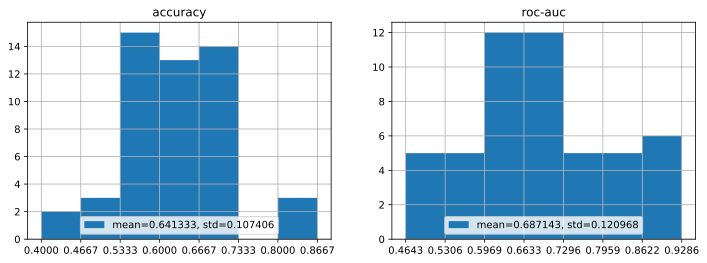

In [149]:
plot_hist(scores)

In [25]:
scores = validation.get_repeated_scores(validation.train_test_val, df_60, features, model, random_state=57, n_repeats=1000, p_bar=1)

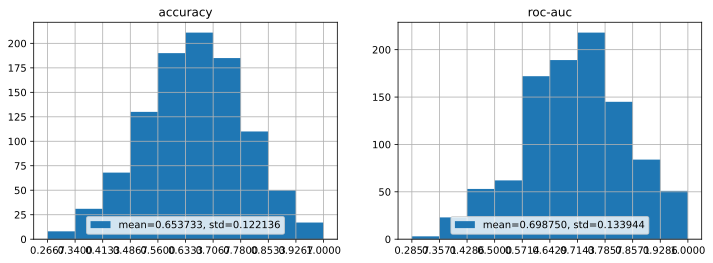

In [30]:
plot_hist(scores)

## Проверка качества на разных временных промежутках

In [6]:
dir_10 = '10s_0_0_10'
dir_20 = '20s_1_20_40'
dir_30 = '30s_0_30_60'
df_10 = get_merged_df(base_path/dir_10, feature_methods)
df_20 = get_merged_df(base_path/dir_20, feature_methods)
df_30 = get_merged_df(base_path/dir_30, feature_methods)

In [155]:
scores_10 = validation.get_repeated_scores(validation.train_test_val, df_10, features, model, random_state=57, n_repeats=50, p_bar=0)
scores_20 = validation.get_repeated_scores(validation.train_test_val, df_20, features, model, random_state=58, n_repeats=50, p_bar=0)
scores_30 = validation.get_repeated_scores(validation.train_test_val, df_30, features, model, random_state=59, n_repeats=50, p_bar=0)

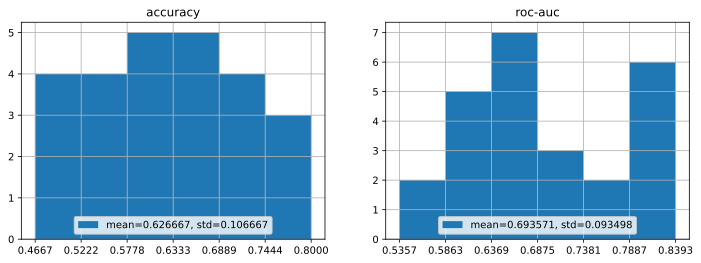

In [156]:
plot_hist(scores_10)

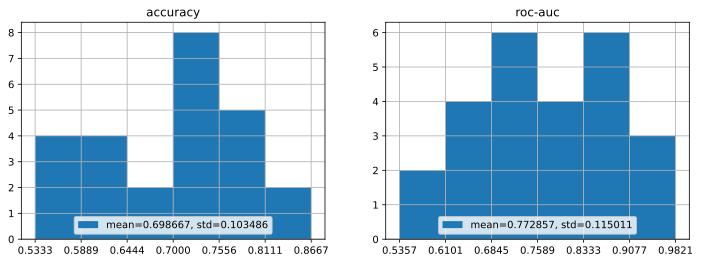

In [157]:
plot_hist(scores_20)

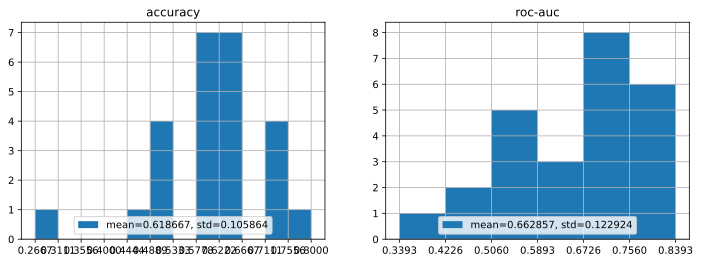

In [158]:
plot_hist(scores_30)

# Расширение выборки данными с разных сегментов

## Сегменты по 20 секунд

In [32]:
dirs = ('20s_0_0_20', '20s_0_20_40', '20s_0_40_60')
dfs = [get_merged_df(base_path/dir, feature_methods) for dir in dirs]

In [34]:
df_combined = merge_segment_dfs(dfs)
df_combined

,env_alpha_t6_t4,env_alpha_t6_o1,env_alpha_t6_f8,env_alpha_t6_p4,env_alpha_t6_c4,env_alpha_t6_t3,env_alpha_t6_f7,env_alpha_t6_f3,env_alpha_t6_o2,env_alpha_t6_f4,...,bands_gamma_fp2,bands_alpha_pz,bands_beta_pz,bands_theta_pz,bands_gamma_pz,bands_alpha_fz,bands_beta_fz,bands_theta_fz,bands_gamma_fz,segment_id
0,0.870393,0.567587,0.554440,0.895187,0.689167,0.575995,0.499339,0.381777,0.819134,0.480975,...,216.687504,56.415201,101.208607,34.930031,22.823477,39.712101,58.244622,55.686948,25.160083,0
1,0.420736,0.611252,0.250627,0.872703,0.449063,0.257476,0.291844,0.461979,0.883611,0.190497,...,28.247635,277.836519,792.811718,41.327118,15.837870,17.590175,52.135590,28.964512,7.674138,0
2,0.509533,0.815516,0.084532,0.937471,0.340312,0.220193,0.280816,0.329036,0.904958,0.132149,...,57.080431,500.921287,23007.456881,550.352949,37.077578,46.381620,54.479990,56.379400,14.382132,0
3,0.690212,0.833748,0.018212,0.959249,-0.036258,0.455499,0.028460,0.207589,0.900893,0.259502,...,41.642549,1014.842993,12988.404049,504.111972,29.791010,370.471951,69.935027,89.885909,21.204293,0
4,0.604002,0.366475,0.390909,0.606259,0.468098,0.264789,0.292011,0.269545,0.449300,0.343879,...,64.625556,22.120517,2512.864056,7.812063,5.670666,257.532144,1295.694373,42.577721,24.532458,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,0.520094,0.437361,0.115152,0.831866,0.031945,0.066460,0.123720,-0.029805,0.733487,0.062897,...,149.060315,93.601570,157.180298,65.772402,33.268822,51.624621,143.351654,67.509088,41.197916,2
263,0.329214,0.495759,0.197549,0.743466,0.062524,0.113722,0.136438,0.033721,0.831543,0.043923,...,264.843386,64.089680,126.088071,26.711315,29.265360,54.633389,82.822221,20.141701,36.330975,2
264,0.445809,0.465056,0.233860,0.794938,0.603754,0.187573,0.026282,0.086192,0.725458,0.086384,...,33.758054,69.866532,77.387773,34.443107,7.935520,38.163571,41.208811,40.590434,15.907149,2
265,0.773073,0.452655,0.388941,0.831534,0.464683,0.388199,0.267770,0.107206,0.808619,0.098189,...,58.704602,218.173143,439.937975,230.165334,12.350488,207.917736,661.114688,150.106561,28.381374,2


In [110]:
scores = validation.get_repeated_scores(validation.multi_segment_train_test, df_combined, features, model, random_state=57, n_repeats=100, p_bar=1)

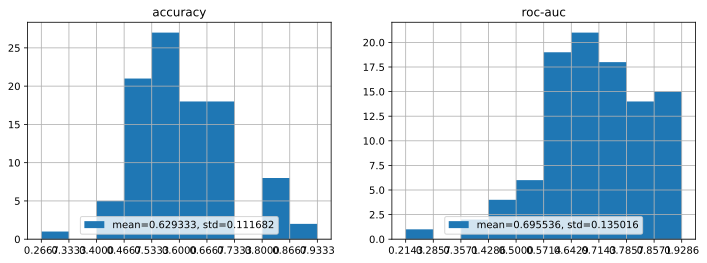

In [112]:
plot_hist(scores)

## Сегмент 60 секунд + сегменты по 30 секунд

In [6]:
dirs = ('60s_0_0_60', '30s_0_0_30', '30s_0_30_60')
dfs = [get_merged_df(base_path/dir, feature_methods) for dir in dirs]

In [7]:
df_combined = merge_segment_dfs(dfs)
df_combined

,env_alpha_t6_t4,env_alpha_t6_o1,env_alpha_t6_f8,env_alpha_t6_p4,env_alpha_t6_c4,env_alpha_t6_t3,env_alpha_t6_f7,env_alpha_t6_f3,env_alpha_t6_o2,env_alpha_t6_f4,...,bands_gamma_fp2,bands_alpha_pz,bands_beta_pz,bands_theta_pz,bands_gamma_pz,bands_alpha_fz,bands_beta_fz,bands_theta_fz,bands_gamma_fz,segment_id
0,0.862693,0.515216,0.597170,0.892104,0.642351,0.569337,0.518653,0.411284,0.817264,0.485622,...,221.493898,90.112141,120.829028,32.557097,27.690337,49.284144,75.045404,37.092665,29.114363,0
1,0.437437,0.699828,0.261864,0.845655,0.325365,0.078983,0.108343,0.403305,0.895111,0.282967,...,29.573109,825.425073,838.467649,87.501929,14.972101,42.288742,59.460554,34.849155,6.850115,0
2,0.564926,0.696259,0.265468,0.907501,0.410815,0.333372,0.343069,0.385072,0.845697,0.272360,...,49.028662,640.294141,20269.218699,941.119542,39.151326,78.004301,53.067848,60.569653,13.471286,0
3,0.523941,0.769406,-0.016689,0.949468,-0.070275,0.239563,-0.001990,0.096925,0.885606,0.143562,...,46.704146,1324.318521,14798.067521,274.858787,30.382727,1049.588928,107.891124,145.558790,23.918301,0
4,0.530864,0.226952,0.293295,0.618569,0.365164,0.187277,0.208643,0.209183,0.499577,0.263025,...,70.342152,23.162862,2246.308997,9.790126,6.412085,260.514405,1156.551266,52.207551,24.711249,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,0.489175,0.486450,0.123809,0.806014,0.114850,0.106739,0.119358,0.050714,0.729906,0.120273,...,150.193862,87.379320,162.842694,72.632665,35.404314,65.008180,144.584359,68.211261,41.564169,2
263,0.302123,0.540185,0.188927,0.764772,0.083107,0.198257,0.153422,0.061481,0.835633,0.042879,...,239.952818,63.814789,150.554951,23.055180,29.502741,51.027734,92.566301,19.454867,34.550197,2
264,0.423219,0.489734,0.251184,0.780031,0.615684,0.224136,0.012462,0.048172,0.516418,0.072647,...,33.866929,89.283670,91.716422,42.232952,8.039117,50.747910,49.218461,43.422994,15.351117,2
265,0.801852,0.537914,0.405386,0.883634,0.547617,0.404888,0.280651,0.135974,0.847887,0.079409,...,56.813260,287.243691,451.329064,365.177952,12.729929,262.832308,721.851253,190.607062,27.875416,2


In [11]:
scores = validation.get_repeated_scores(validation.multi_segment_train_test, df_combined, features, model, random_state=57, n_repeats=100, p_bar=1)

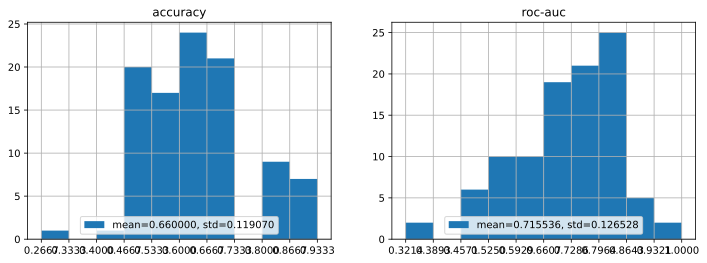

In [15]:
plot_hist(scores)

# Оптимизация accuracy при отборе признаков

In [16]:
scores = validation.get_repeated_scores(validation.train_test_val, df_60, features, model, random_state=57, n_repeats=500, p_bar=1, metric='acc')

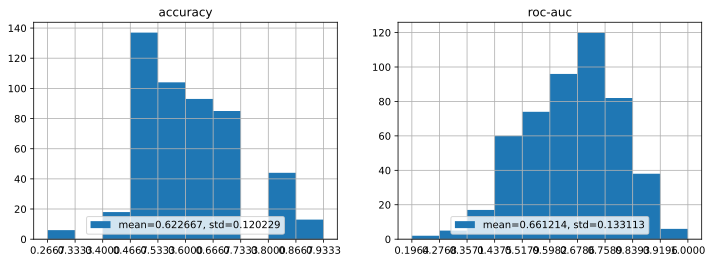

In [20]:
plot_hist(scores)